## This notebook shows how to use Orchestrator APIs for user experiments

In [1]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json

In [2]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

CM Host: cm.fabric-testbed.net Orchestrator Host: orchestrator.fabric-testbed.net


In [3]:
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, project_name='all', scope='all')

# Initialize the slice manager
slice_manager.initialize()

In [4]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: TACC: { cpu: 10/10 , core: 320/320 , ram: 2,560/2,560 G, disk: 116,400/116,400 G, unit: 5/5 }
	Components:
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 15,360/15,360 G, unit: 16/16 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 635/635 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		GPU-RTX6000:  GPU RTX6000 { unit: 6/6 }
	Site Interfaces:
		TACC_UTAH: TrunkPort { bw: 100/100 Gbps}
		TACC_MAX: TrunkPort { bw: 100/100 Gbps}
NCSA: { cpu: 6/6 , core: 192/192 , ram: 1,536/1,536 G, disk: 60,600/60,600 G, unit: 3/3 }
	Components:
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		NVME-P4510:  NVME P4510 { disk: 9,600/9,600 G, unit: 10/10 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 3/3 }


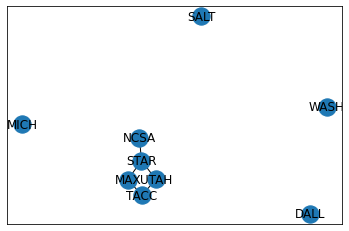

In [5]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice

In [6]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()


# Add node
n1 = t.add_node(name='master_node', site='MAX')

# Set capacities
cap = Capacities()
cap.set_fields(core=2, ram=4, disk=10)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')


# Add node
n2 = t.add_node(name='client_node', site='MAX')

# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')


# Generate Slice Graph
slice_graph = t.serialize()

ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='Slice-Kubernetes-Hello-World', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "3e9dcab9-92a5-44ae-acf7-463cd3c94075",
    "lease_end": "2021-11-04 02:39:26",
    "pending_state": "None_",
    "reservation_id": "919c9695-4aaf-44d8-9f41-bc1e28edc8ff",
    "reservation_state": "Unknown",
    "slice_id": "a0e8e3db-aa36-461c-b1c9-9585effebcb6"
}, {
    "graph_node_id": "9abf6794-8114-42e9-be9a-9e24a7e71e36",
    "lease_end": "2021-11-04 02:39:26",
    "pending_state": "None_",
    "reservation_id": "1b351520-dff7-4408-825d-2b5632817641",
    "reservation_state": "Unknown",
    "slice_id": "a0e8e3db-aa36-461c-b1c9-9585effebcb6"
}]


In [7]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id
print(slice_id)

a0e8e3db-aa36-461c-b1c9-9585effebcb6


## Query Slices

In [8]:
status, slices = slice_manager.slices()

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))
else:
    print(f"Failure: {slices}")

Response Status Status.OK
Slices [{
    "graph_id": "e02ad13c-dba9-47c4-9826-09aeeb072e0f",
    "lease_end": "2021-11-04 02:39:26",
    "slice_id": "a0e8e3db-aa36-461c-b1c9-9585effebcb6",
    "slice_name": "Slice-Kubernetes-Hello-World",
    "slice_state": "Configuring"
}]


### We wait for the slice to become StableOK.

In [10]:
status, slices = slice_manager.slices()

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))
else:
    print(f"Failure: {slices}")

Response Status Status.OK
Slices [{
    "graph_id": "e02ad13c-dba9-47c4-9826-09aeeb072e0f",
    "lease_end": "2021-11-04 02:39:26",
    "slice_id": "a0e8e3db-aa36-461c-b1c9-9585effebcb6",
    "slice_name": "Slice-Kubernetes-Hello-World",
    "slice_state": "StableOK"
}]


## Query Slivers

In [12]:
slice_object = list(filter(lambda x: x.slice_id == slice_id, slices))[0]
status, slivers = slice_manager.slivers(slice_object=slice_object)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))
else:
    print(f"Failure: {slivers}")

Response Status Status.OK
Slivers [{
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-00000519\", \"instance_parent\": \"max-w3.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 4}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "3e9dcab9-92a5-44ae-acf7-463cd3c94075",
    "join_state": "NoJoin",
    "lease_end": "2021-11-04 02:39:26",
    "management_ip": "63.239.135.71",
    "name": "master_node",
    "notices": "Reservation 919c9695-4aaf-44d8-9f41-bc1e28edc8ff (Slice Slice-Kubernetes-Hello-World(a0e8e3db-aa36-461c-b1c9-9585effebcb6) Graph Id:e02ad13c-dba9-47c4-9826-09aeeb072e0f Owner:name: orchestrator guid: orchestrator-guid email: minawm@bu.edu State:StableOK ) is in state [Active,None_]\n\nLast ticket update: \nTicket events: \nLast ticket update: \nTicket events: ",
    "pending_state": "None_",
    "reservation_id": "919c9695-4aaf-44d8-

## Sliver Status

In [13]:
for s in slivers:
    status, sliver_status = slice_manager.sliver_status(sliver=s)

    print("Response Status {}".format(status))
    if status == Status.OK:
        print()
        print("Sliver Status {}".format(sliver_status))
        print()

Response Status Status.OK

Sliver Status {
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-00000519\", \"instance_parent\": \"max-w3.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 4}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "3e9dcab9-92a5-44ae-acf7-463cd3c94075",
    "join_state": "NoJoin",
    "lease_end": "2021-11-04 02:39:26",
    "management_ip": "63.239.135.71",
    "name": "master_node",
    "notices": "Reservation 919c9695-4aaf-44d8-9f41-bc1e28edc8ff (Slice Slice-Kubernetes-Hello-World(a0e8e3db-aa36-461c-b1c9-9585effebcb6) Graph Id:e02ad13c-dba9-47c4-9826-09aeeb072e0f Owner:name: orchestrator guid: orchestrator-guid email: minawm@bu.edu State:StableOK ) is in state [Active,None_]\n\nLast ticket update: \nTicket events: \nLast ticket update: \nTicket events: ",
    "pending_state": "None_",
    "reservation_id": "919c9695-4aaf

## Work on the servers starts here.

### We are going to use paramiko to connect to our servers through ssh.

In [14]:
import paramiko

### We have two servers with two IPs.

In [15]:
master_node_ip = list(filter(lambda sliver : sliver.name == "master_node",slivers))[0].management_ip
master_node_ip

'63.239.135.71'

In [16]:
client_node_ip = list(filter(lambda sliver : sliver.name == "client_node",slivers))[0].management_ip
client_node_ip

'63.239.135.85'

### Below, we connect to our first server.

In [17]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
master_node = paramiko.SSHClient()
master_node.load_system_host_keys()
master_node.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

master_node.set_missing_host_key_policy(paramiko.AutoAddPolicy())
master_node.connect(master_node_ip,username='ubuntu',pkey = key)

master_node

### Connection should be established. Let's issue some test commands:

In [18]:
stdin, stdout, stderr = master_node.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.3 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



In [19]:
stdin, stdout, stderr = master_node.exec_command('ip addr')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:d5:db:ab brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.205/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86233sec preferred_lft 86233sec
    inet6 fe80::f816:3eff:fed5:dbab/64 scope link 
       valid_lft forever preferred_lft forever




In [20]:
stdin, stdout, stderr = master_node.exec_command('curl https://ipinfo.io/ip')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

63.239.135.71
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    13  100    13    0     0    131      0 --:--:-- --:--:-- --:--:--   131



### Now we connect to our second server.

In [21]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client_node = paramiko.SSHClient()
client_node.load_system_host_keys()
client_node.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client_node.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client_node.connect(client_node_ip,username='ubuntu',pkey = key)

client_node

### Again, some test commands.

In [22]:
stdin, stdout, stderr = client_node.exec_command('curl https://ipinfo.io/ip')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

63.239.135.85
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    13  100    13    0     0    232      0 --:--:-- --:--:-- --:--:--   232



### Now, let's do a quick ping experiment. Let's let each of the servers ping the other server.

In [23]:
stdin, stdout, stderr = client_node.exec_command('ping -c 10 ' + master_node_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 63.239.135.71 (63.239.135.71) 56(84) bytes of data.
64 bytes from 63.239.135.71: icmp_seq=1 ttl=63 time=0.570 ms
64 bytes from 63.239.135.71: icmp_seq=2 ttl=63 time=0.816 ms
64 bytes from 63.239.135.71: icmp_seq=3 ttl=63 time=0.662 ms
64 bytes from 63.239.135.71: icmp_seq=4 ttl=63 time=0.383 ms
64 bytes from 63.239.135.71: icmp_seq=5 ttl=63 time=0.418 ms
64 bytes from 63.239.135.71: icmp_seq=6 ttl=63 time=0.460 ms
64 bytes from 63.239.135.71: icmp_seq=7 ttl=63 time=0.331 ms
64 bytes from 63.239.135.71: icmp_seq=8 ttl=63 time=0.403 ms
64 bytes from 63.239.135.71: icmp_seq=9 ttl=63 time=0.319 ms
64 bytes from 63.239.135.71: icmp_seq=10 ttl=63 time=0.316 ms

--- 63.239.135.71 ping statistics ---
10 packets transmitted, 10 received, 0% packet loss, time 9224ms
rtt min/avg/max/mdev = 0.316/0.467/0.816/0.157 ms




In [24]:
stdin, stdout, stderr = master_node.exec_command('ping -c 10 ' + client_node_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 63.239.135.85 (63.239.135.85) 56(84) bytes of data.
64 bytes from 63.239.135.85: icmp_seq=1 ttl=63 time=0.222 ms
64 bytes from 63.239.135.85: icmp_seq=2 ttl=63 time=0.382 ms
64 bytes from 63.239.135.85: icmp_seq=3 ttl=63 time=0.314 ms
64 bytes from 63.239.135.85: icmp_seq=4 ttl=63 time=0.359 ms
64 bytes from 63.239.135.85: icmp_seq=5 ttl=63 time=0.367 ms
64 bytes from 63.239.135.85: icmp_seq=6 ttl=63 time=0.350 ms
64 bytes from 63.239.135.85: icmp_seq=7 ttl=63 time=0.323 ms
64 bytes from 63.239.135.85: icmp_seq=8 ttl=63 time=0.311 ms
64 bytes from 63.239.135.85: icmp_seq=9 ttl=63 time=0.317 ms
64 bytes from 63.239.135.85: icmp_seq=10 ttl=63 time=0.333 ms

--- 63.239.135.85 ping statistics ---
10 packets transmitted, 10 received, 0% packet loss, time 9193ms
rtt min/avg/max/mdev = 0.222/0.327/0.382/0.042 ms




### Ping experiment complete. Both nodes can see each other.

### Now, let's start a Kubernetes cluster on those two nodes.

We follow the instructions that we have here: https://github.com/apache/openwhisk-deploy-kube/blob/master/docs/k8s-diy-ubuntu.md

## Master node setup.

We now simply follow the instructions on our master node one by one.

In [25]:
stdin, stdout, stderr = master_node.exec_command('sudo apt update')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [949 kB]
Get:5 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease [101 kB]
Get:6 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [178 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [8844 B]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [483 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [69.2 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [508 B]
Get:12 http://security.ubuntu.com/ubuntu focal-security/univer

In [26]:
stdin, stdout, stderr = master_node.exec_command('sudo apt-get install -y docker.io')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  bridge-utils containerd dns-root-data dnsmasq-base libidn11 pigz runc
  ubuntu-fan
Suggested packages:
  ifupdown aufs-tools cgroupfs-mount | cgroup-lite debootstrap docker-doc
  rinse zfs-fuse | zfsutils
The following NEW packages will be installed:
  bridge-utils containerd dns-root-data dnsmasq-base docker.io libidn11 pigz
  runc ubuntu-fan
0 upgraded, 9 newly installed, 0 to remove and 58 not upgraded.
Need to get 74.3 MB of archives.
After this operation, 360 MB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 pigz amd64 2.4-1 [57.4 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 bridge-utils amd64 1.6-2ubuntu1 [30.5 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 runc amd64 1.0.0~rc95-0ubuntu1~20.04.2 [4087 kB]
Get:4 http://nova.

In [27]:
stdin, stdout, stderr = master_node.exec_command('sudo apt-get update && sudo apt-get install -y apt-transport-https curl')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease [101 kB]
Get:5 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [1302 kB]
Get:6 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [14.4 kB]
Get:7 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [867 kB]
Get:8 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [19.4 kB]
Fetched 2417 kB in 1s (1900 kB/s)
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libcurl4
The following NEW packages will be installed:
  apt-transport-https
The following packages wil

In [28]:
stdin, stdout, stderr = master_node.exec_command('curl -s https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

OK




In [29]:
stdin, stdout, stderr = master_node.exec_command('cat <<EOF | sudo tee /etc/apt/sources.list.d/kubernetes.list\ndeb https://apt.kubernetes.io/ kubernetes-xenial main\nEOF\n')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

deb https://apt.kubernetes.io/ kubernetes-xenial main




In [30]:
stdin, stdout, stderr = master_node.exec_command('cat /etc/apt/sources.list.d/kubernetes.list')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

deb https://apt.kubernetes.io/ kubernetes-xenial main




In [31]:
stdin, stdout, stderr = master_node.exec_command('sudo apt-get update')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:5 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease
Get:4 https://packages.cloud.google.com/apt kubernetes-xenial InRelease [9383 B]
Get:6 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 Packages [50.9 kB]
Fetched 60.3 kB in 1s (67.6 kB/s)
Reading package lists...




In [32]:
stdin, stdout, stderr = master_node.exec_command('sudo apt-get install -y kubelet kubeadm kubectl')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  conntrack cri-tools ebtables kubernetes-cni socat
Suggested packages:
  nftables
The following NEW packages will be installed:
  conntrack cri-tools ebtables kubeadm kubectl kubelet kubernetes-cni socat
0 upgraded, 8 newly installed, 0 to remove and 56 not upgraded.
Need to get 73.5 MB of archives.
After this operation, 318 MB of additional disk space will be used.
Get:5 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 conntrack amd64 1:1.4.5-2 [30.3 kB]
Get:1 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 cri-tools amd64 1.19.0-00 [11.2 MB]
Get:7 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 ebtables amd64 2.0.11-3build1 [80.3 kB]
Get:8 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 socat amd64 1.7.3.3-2 [323 kB]
Get:2 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 ku

In [33]:
stdin, stdout, stderr = master_node.exec_command('sudo apt-mark hold kubelet kubeadm kubectl')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

kubelet set on hold.
kubeadm set on hold.
kubectl set on hold.




In [34]:
stdin, stdout, stderr = master_node.exec_command('sudo swapoff -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### We also need to do some configuration to docker.

In [35]:
stdin, stdout, stderr = master_node.exec_command('cat <<EOF | sudo tee /etc/docker/daemon.json\n{\n"exec-opts": ["native.cgroupdriver=systemd"]\n}\nEOF\n')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

{
"exec-opts": ["native.cgroupdriver=systemd"]
}




In [36]:
stdin, stdout, stderr = master_node.exec_command('sudo systemctl enable docker && sudo systemctl daemon-reload && sudo systemctl restart docker')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### The setup part is complete. Now, we issue the kubeadm init command below:

In [37]:
stdin, stdout, stderr = master_node.exec_command('sudo kubeadm init --pod-network-cidr=192.168.0.0/16 --apiserver-advertise-address=0.0.0.0')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

[init] Using Kubernetes version: v1.22.3
[preflight] Running pre-flight checks
[preflight] Pulling images required for setting up a Kubernetes cluster
[preflight] This might take a minute or two, depending on the speed of your internet connection
[preflight] You can also perform this action in beforehand using 'kubeadm config images pull'
[certs] Using certificateDir folder "/etc/kubernetes/pki"
[certs] Generating "ca" certificate and key
[certs] Generating "apiserver" certificate and key
[certs] apiserver serving cert is signed for DNS names [919c9695-4aaf-44d8-9f41-bc1e28edc8ff-master-node kubernetes kubernetes.default kubernetes.default.svc kubernetes.default.svc.cluster.local] and IPs [10.96.0.1 10.20.4.205]
[certs] Generating "apiserver-kubelet-client" certificate and key
[certs] Generating "front-proxy-ca" certificate and key
[certs] Generating "front-proxy-client" certificate and key
[certs] Generating "etcd/ca" certificate and key
[certs] Generating "etcd/server" certificate an

### As stated, the initialization was successful. Note that we need to save the join command somewhere, because we will need to use it later at the client.

In [38]:
stdin, stdout, stderr = master_node.exec_command('mkdir -p $HOME/.kube')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [39]:
stdin, stdout, stderr = master_node.exec_command('sudo cp -i /etc/kubernetes/admin.conf $HOME/.kube/config')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [40]:
stdin, stdout, stderr = master_node.exec_command('sudo chown $(id -u):$(id -g) $HOME/.kube/config')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [41]:
stdin, stdout, stderr = master_node.exec_command('kubectl apply -f https://docs.projectcalico.org/manifests/calico.yaml')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

configmap/calico-config created
customresourcedefinition.apiextensions.k8s.io/bgpconfigurations.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/bgppeers.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/blockaffinities.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/clusterinformations.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/felixconfigurations.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/globalnetworkpolicies.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/globalnetworksets.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/hostendpoints.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/ipamblocks.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/ipamconfigs.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/ip

In [42]:
stdin, stdout, stderr = master_node.exec_command('kubectl get nodes')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

NAME                                               STATUS     ROLES                  AGE   VERSION
919c9695-4aaf-44d8-9f41-bc1e28edc8ff-master-node   NotReady   control-plane,master   24s   v1.22.3




### We need to wait for just a few more seconds for the STATUS to change to Ready.

In [44]:
stdin, stdout, stderr = master_node.exec_command('kubectl get nodes')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

NAME                                               STATUS   ROLES                  AGE   VERSION
919c9695-4aaf-44d8-9f41-bc1e28edc8ff-master-node   Ready    control-plane,master   40s   v1.22.3




### It is now ready.

## Client side setup.

### We are now done with the server. Let's do the client. Remember, we are following the instructions in the link that we have previously mentioned.

In [45]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-get update')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [949 kB]
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [178 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [8844 B]
Get:6 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [483 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [69.2 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [508 B]
Get:9 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [647 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [106 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [12.8 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-secur

In [46]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-get install -y docker.io')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  bridge-utils containerd dns-root-data dnsmasq-base libidn11 pigz runc
  ubuntu-fan
Suggested packages:
  ifupdown aufs-tools cgroupfs-mount | cgroup-lite debootstrap docker-doc
  rinse zfs-fuse | zfsutils
The following NEW packages will be installed:
  bridge-utils containerd dns-root-data dnsmasq-base docker.io libidn11 pigz
  runc ubuntu-fan
0 upgraded, 9 newly installed, 0 to remove and 58 not upgraded.
Need to get 74.3 MB of archives.
After this operation, 360 MB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 pigz amd64 2.4-1 [57.4 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 bridge-utils amd64 1.6-2ubuntu1 [30.5 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 runc amd64 1.0.0~rc95-0ubuntu1~20.04.2 [4087 kB]
Get:4 http://nova.

In [47]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-get update && sudo apt-get install -y apt-transport-https curl')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libcurl4
The following NEW packages will be installed:
  apt-transport-https
The following packages will be upgraded:
  curl libcurl4
2 upgraded, 1 newly installed, 0 to remove and 56 not upgraded.
Need to get 400 kB of archives.
After this operation, 164 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/universe amd64 apt-transport-https all 2.0.6 [4680 B]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.7 [161 kB]
Get:3 http://nova.cloud

In [48]:
stdin, stdout, stderr = client_node.exec_command('curl -s https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

OK




In [49]:
stdin, stdout, stderr = client_node.exec_command('cat <<EOF | sudo tee /etc/apt/sources.list.d/kubernetes.list\ndeb https://apt.kubernetes.io/ kubernetes-xenial main\nEOF\n')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

deb https://apt.kubernetes.io/ kubernetes-xenial main




In [50]:
stdin, stdout, stderr = client_node.exec_command('cat /etc/apt/sources.list.d/kubernetes.list')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

deb https://apt.kubernetes.io/ kubernetes-xenial main




In [51]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-get update')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease
Get:5 https://packages.cloud.google.com/apt kubernetes-xenial InRelease [9383 B]
Get:6 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 Packages [50.9 kB]
Fetched 60.3 kB in 1s (69.8 kB/s)
Reading package lists...




In [52]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-get install -y kubelet kubeadm kubectl')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  conntrack cri-tools ebtables kubernetes-cni socat
Suggested packages:
  nftables
The following NEW packages will be installed:
  conntrack cri-tools ebtables kubeadm kubectl kubelet kubernetes-cni socat
0 upgraded, 8 newly installed, 0 to remove and 56 not upgraded.
Need to get 73.5 MB of archives.
After this operation, 318 MB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 conntrack amd64 1:1.4.5-2 [30.3 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 ebtables amd64 2.0.11-3build1 [80.3 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 socat amd64 1.7.3.3-2 [323 kB]
Get:3 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 cri-tools amd64 1.19.0-00 [11.2 MB]
Get:5 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 ku

In [53]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-mark hold kubelet kubeadm kubectl')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

kubelet set on hold.
kubeadm set on hold.
kubectl set on hold.




In [54]:
stdin, stdout, stderr = client_node.exec_command('sudo swapoff -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [55]:
stdin, stdout, stderr = client_node.exec_command('cat <<EOF | sudo tee /etc/docker/daemon.json\n{\n"exec-opts": ["native.cgroupdriver=systemd"]\n}\nEOF\n')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

{
"exec-opts": ["native.cgroupdriver=systemd"]
}




In [56]:
stdin, stdout, stderr = client_node.exec_command('sudo systemctl enable docker && sudo systemctl daemon-reload && sudo systemctl restart docker')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### The setup part is complete. Now we need to do the join command. We do it like this:

As a note. When we do "kubeadm init" in the server, it prints the join command for us. What we do is that we copy it and paste it in the client. And don't forget to add sudo.

In [57]:
stdin, stdout, stderr = client_node.exec_command('sudo kubeadm join 10.20.4.205:6443 --token fbdedw.1ykngdgydw3ti9ru --discovery-token-ca-cert-hash sha256:963809972d60c5ed1f62346753e2f93537a98f891d19caaeeba509f7e9d346ab')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

[preflight] Running pre-flight checks
[preflight] Reading configuration from the cluster...
[preflight] FYI: You can look at this config file with 'kubectl -n kube-system get cm kubeadm-config -o yaml'
[kubelet-start] Writing kubelet configuration to file "/var/lib/kubelet/config.yaml"
[kubelet-start] Writing kubelet environment file with flags to file "/var/lib/kubelet/kubeadm-flags.env"
[kubelet-start] Starting the kubelet
[kubelet-start] Waiting for the kubelet to perform the TLS Bootstrap...

This node has joined the cluster:
* Certificate signing request was sent to apiserver and a response was received.
* The Kubelet was informed of the new secure connection details.

Run 'kubectl get nodes' on the control-plane to see this node join the cluster.





### Let's check back at the server.

In [59]:
stdin, stdout, stderr = master_node.exec_command('kubectl get nodes')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

NAME                                               STATUS   ROLES                  AGE     VERSION
1b351520-dff7-4408-825d-2b5632817641-client-node   Ready    <none>                 16s     v1.22.3
919c9695-4aaf-44d8-9f41-bc1e28edc8ff-master-node   Ready    control-plane,master   2m42s   v1.22.3




### We can see that the worker node is connected. Task complete.

### The next task is to deploy a hello world application.

First, we pull a hello world image and create a "deployment".

In [60]:
stdin, stdout, stderr = master_node.exec_command('kubectl create deployment kubernetes-bootcamp --image=gcr.io/google-samples/kubernetes-bootcamp:v1')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

deployment.apps/kubernetes-bootcamp created




### Now let's do some status commands. They just show us some information.

In [62]:
stdin, stdout, stderr = master_node.exec_command('kubectl get pods --all-namespaces')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

NAMESPACE     NAME                                                                       READY   STATUS    RESTARTS   AGE
default       kubernetes-bootcamp-57978f5f5d-s5skp                                       1/1     Running   0          56s
kube-system   calico-kube-controllers-75f8f6cc59-x6tbq                                   1/1     Running   0          3m21s
kube-system   calico-node-d8wnz                                                          1/1     Running   0          76s
kube-system   calico-node-ttcgx                                                          1/1     Running   0          3m21s
kube-system   coredns-78fcd69978-f9t75                                                   1/1     Running   0          3m25s
kube-system   coredns-78fcd69978-rnndw                                                   1/1     Running   0          3m25s
kube-system   etcd-919c9695-4aaf-44d8-9f41-bc1e28edc8ff-master-node                      1/1     Running   0          3m38s
kube-system   

### For the following status command, make sure to use the correct pod name.

In [63]:
stdin, stdout, stderr = master_node.exec_command('kubectl describe pod kubernetes-bootcamp-57978f5f5d-s5skp')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Name:         kubernetes-bootcamp-57978f5f5d-s5skp
Namespace:    default
Priority:     0
Node:         1b351520-dff7-4408-825d-2b5632817641-client-node/10.20.4.196
Start Time:   Wed, 03 Nov 2021 02:48:32 +0000
Labels:       app=kubernetes-bootcamp
              pod-template-hash=57978f5f5d
Annotations:  cni.projectcalico.org/containerID: 07955a71768fda5ce1defdbb4c8ba36c4ab3159efa107d3ee0102f1ecf3cbbb9
              cni.projectcalico.org/podIP: 192.168.59.193/32
              cni.projectcalico.org/podIPs: 192.168.59.193/32
Status:       Running
IP:           192.168.59.193
IPs:
  IP:           192.168.59.193
Controlled By:  ReplicaSet/kubernetes-bootcamp-57978f5f5d
Containers:
  kubernetes-bootcamp:
    Container ID:   docker://3f23640298c3e8d65880a116a8dca3aa382d4af54749efb5f2a2b2dabfc3d311
    Image:          gcr.io/google-samples/kubernetes-bootcamp:v1
    Image ID:       docker-pullable://gcr.io/google-samples/kubernetes-bootcamp@sha256:0d6b8ee63bb57c5f5b6156f446b3bc3b3c143d233037f3

The next thing we need to do is to create what is called a "service". We are going to use it to expose the deployment to the outside, through a port, which is 8080. Like this:

_Note that the service itself will still need to be exposed. There's another "expose" step that we need to make._

In [64]:
stdin, stdout, stderr = master_node.exec_command('kubectl expose deployment/kubernetes-bootcamp --type="ClusterIP" --port 8080')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

service/kubernetes-bootcamp exposed




### Let's check if the service was created.

In [65]:
stdin, stdout, stderr = master_node.exec_command('kubectl get service kubernetes-bootcamp')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

NAME                  TYPE        CLUSTER-IP       EXTERNAL-IP   PORT(S)    AGE
kubernetes-bootcamp   ClusterIP   10.104.214.203   <none>        8080/TCP   3s




### Finally, we need to run a port forwarding command in order to expose the service to the outside.

In [66]:
stdin, stdout, stderr = master_node.exec_command('kubectl port-forward --address 0.0.0.0 service/kubernetes-bootcamp 8080:8080 > /dev/null 2>&1 &')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### Now our application should finally be visible. Let's test the deployment on the master machine itself.

In [67]:
stdin, stdout, stderr = master_node.exec_command('curl localhost:8080')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hello Kubernetes bootcamp! | Running on: kubernetes-bootcamp-57978f5f5d-s5skp | v=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    84    0    84    0     0   5250      0 --:--:-- --:--:-- --:--:--  5250



It works! Now let's test it remotely, from our notebook.

In [68]:
import requests

x = requests.get('http://' + master_node_ip + ':8080') #, verify=False)
print(x.status_code)
print(x.content)

200
b'Hello Kubernetes bootcamp! | Running on: kubernetes-bootcamp-57978f5f5d-s5skp | v=1\n'


### We can see above that we can access the application. Experiment complete.

## Delete Slice

You can now delete the slice using the cell below.

In [70]:
status, result = slice_manager.delete(slice_object=slice_object)

print("Response Status {}".format(status))
print("Response received {}".format(result))

Response Status Status.OK
Response received None
